In [1]:
import numpy as np
import cv2
import os, glob

In [2]:
parasitized_dir = glob.glob('./Parasitized/*.png')
uninfected_dir = glob.glob('./Uninfected/*.png')
print(len(parasitized_dir), len(uninfected_dir))

13779 13779


In [4]:
from tqdm import tqdm

width = 128
height = 128

image = []
label = []

task1 = tqdm(parasitized_dir)
task2 = tqdm(uninfected_dir)

for img_path in task1:    
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    img = np.transpose(img, (2, 0, 1)) / 255
    image.append(img)
    label.append(0)

for img_path in task2:    
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    img = np.transpose(img, (2, 0, 1)) / 255
    image.append(img)
    label.append(1)

image = np.array(image)
label = np.array(label)
print(image.shape, label.shape)

100%|██████████| 13779/13779 [00:36<00:00, 376.66it/s]
(27558, 3, 128, 128)(27558,)


In [5]:
classes = ['parasitized', 'uninfected']

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [7]:
x_train = torch.FloatTensor(image)
y_train = torch.IntTensor(label)

In [8]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [24558, 3000])

In [9]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

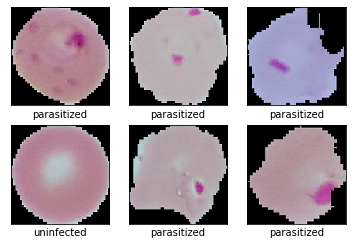

In [11]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()

fig = plt.figure()
rows = 2
cols = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(rows, cols, i + 1)
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_xlabel(classes[int(labels[i])])
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= rows * cols:
        break

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, 5),
            nn.ReLU(),
            nn.Conv2d(32, 2, 5),
            nn.ReLU(),
        )
        
        self.avg_pool = nn.AvgPool2d(128 // 8)
        self.classifier = nn.Linear(2, 2)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        features = self.layer3(x)

        flatten = self.avg_pool(features).view(features.size(0), -1)

        output = self.classifier(flatten)

        return output, features

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 2, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
  )
  (avg_pool): AvgPool2d(kernel_size=16, stride=16, padding=0)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)

In [34]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [36]:
train_losses, val_losses, accuracy = [], [], []
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()

        optimizer.zero_grad()

        outputs, features = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        acc = 0
        
        with torch.no_grad():
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_label = val_label.long()
                
                val_outputs, features = net(val_image)
                _, top_class = val_outputs.topk(1, dim=1)
                pred = top_class.cpu().numpy()
                batch, _ = pred.shape
                target = (val_label.cpu().numpy()).reshape(batch, 1)
                
                correct = np.sum(pred == target)
                acc += correct / batch
                
                val_loss += criterion(val_outputs, val_label)

        acc = acc / len(val_loader)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        accuracy.append(acc)

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} || ".format(val_loss/len(val_loader)),
              "Val ACC : {:.5f}".format(acc)
             )

print('Finished Training')

Epoch: 1/10 ||Training Loss: 0.28381 ||Val Loss: 0.25757 ||Val ACC : 0.92908
Epoch: 2/10 ||Training Loss: 0.25046 ||Val Loss: 0.28416 ||Val ACC : 0.92453
Epoch: 3/10 ||Training Loss: 0.23566 ||Val Loss: 0.23125 ||Val ACC : 0.93573
Epoch: 4/10 ||Training Loss: 0.22460 ||Val Loss: 0.22160 ||Val ACC : 0.93207
Epoch: 5/10 ||Training Loss: 0.22136 ||Val Loss: 0.23592 ||Val ACC : 0.92021
Epoch: 6/10 ||Training Loss: 0.21485 ||Val Loss: 0.23150 ||Val ACC : 0.93484
Epoch: 7/10 ||Training Loss: 0.21721 ||Val Loss: 0.23722 ||Val ACC : 0.92487
Epoch: 8/10 ||Training Loss: 0.20277 ||Val Loss: 0.20624 ||Val ACC : 0.93661
Epoch: 9/10 ||Training Loss: 0.19694 ||Val Loss: 0.19953 ||Val ACC : 0.93872
Epoch: 10/10 ||Training Loss: 0.18702 ||Val Loss: 0.19493 ||Val ACC : 0.94238
Finished Training


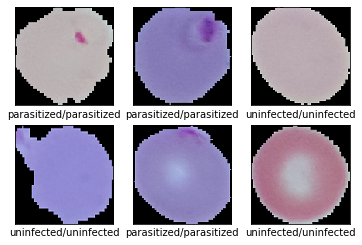

In [38]:
dataiter = iter(val_loader)
inputs, labels = dataiter.next()
images = inputs.numpy()
labels = labels.numpy()

outputs, features = net(inputs.to(device))
outputs.cpu().detach().numpy()
_, outputs = outputs.topk(1, dim=1)

fig = plt.figure()
rows = 2
cols = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(rows, cols, i + 1)
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_xlabel(classes[int(labels[i])] + '/' + classes[int(outputs[i])])
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= rows * cols:
        break

torch.Size([32, 2])torch.Size([32, 2, 18, 18])


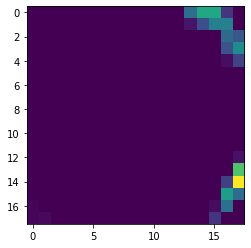

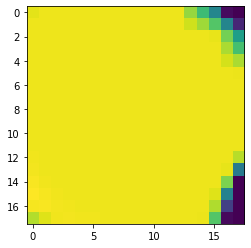

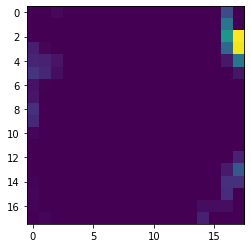

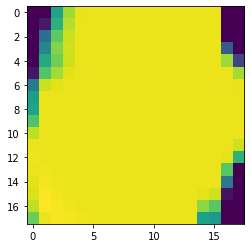

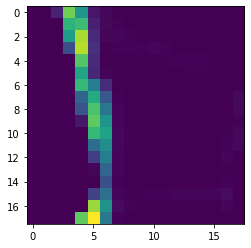

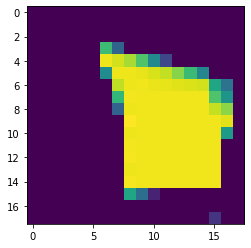

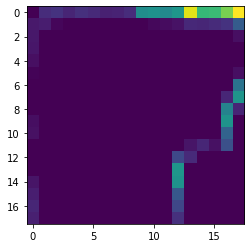

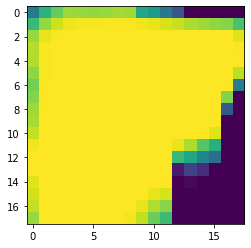

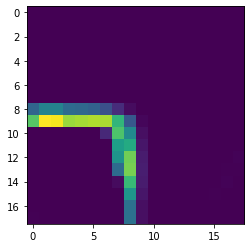

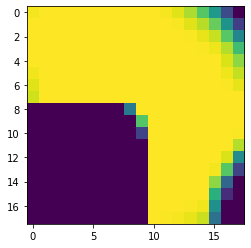

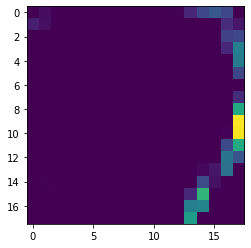

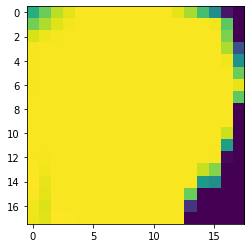

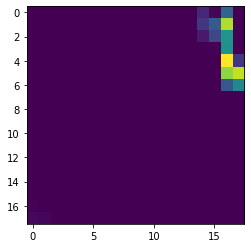

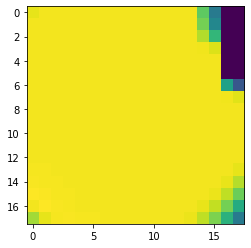

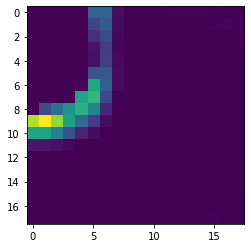

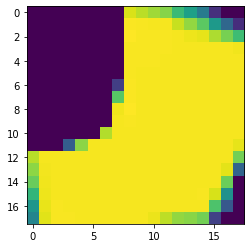

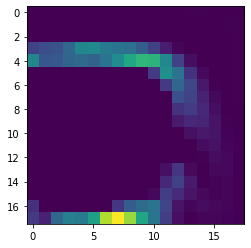

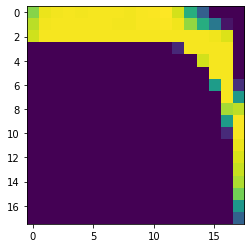

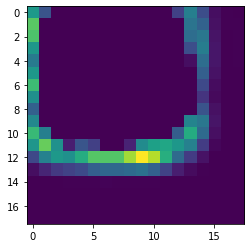

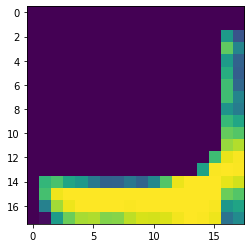

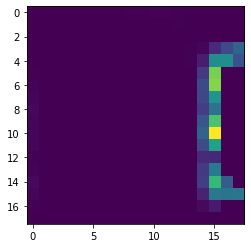

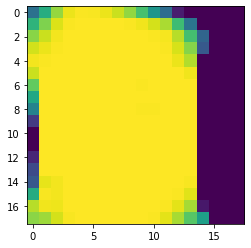

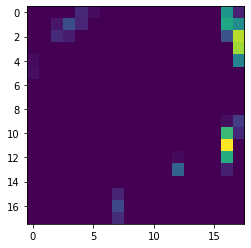

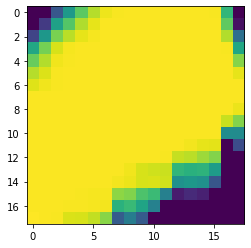

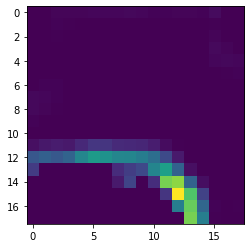

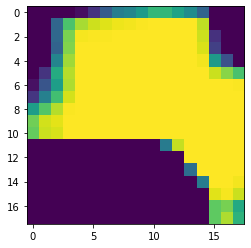

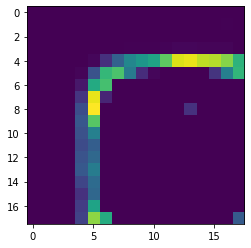

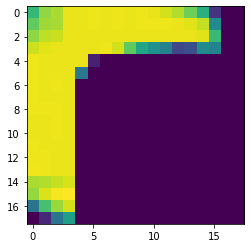

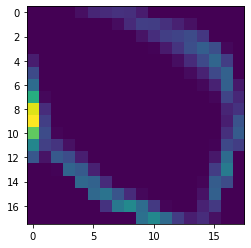

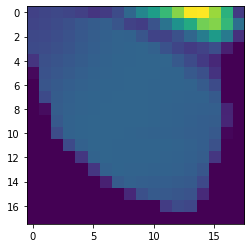

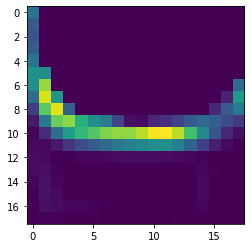

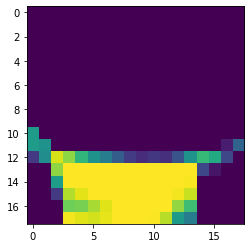

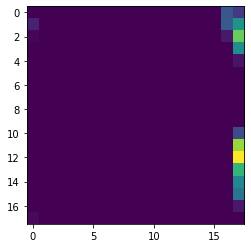

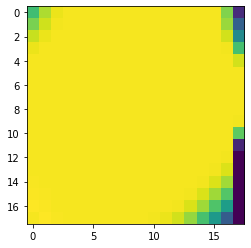

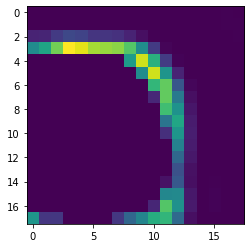

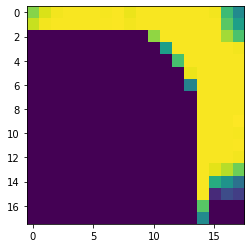

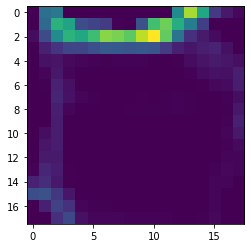

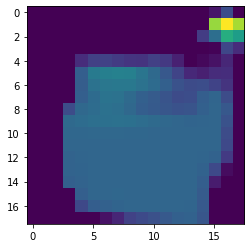

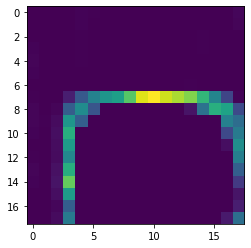

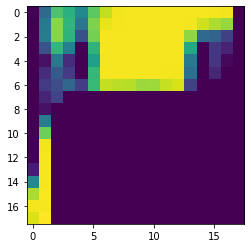

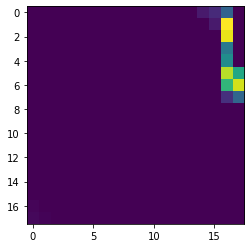

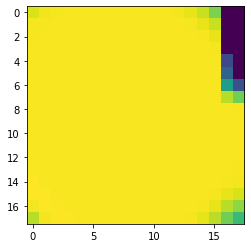

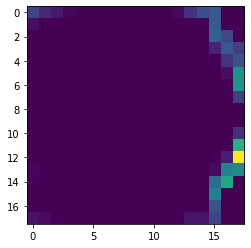

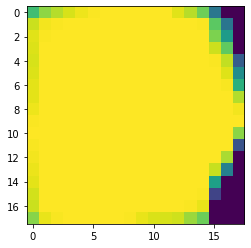

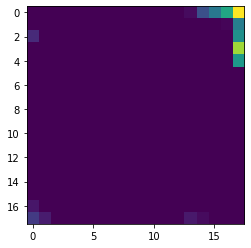

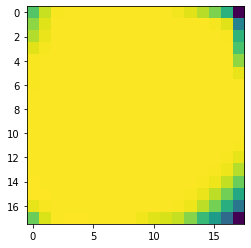

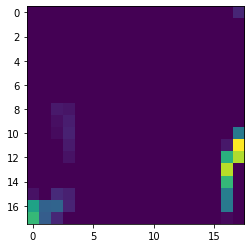

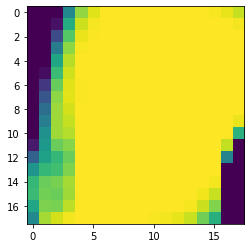

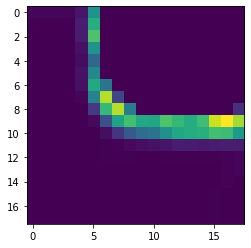

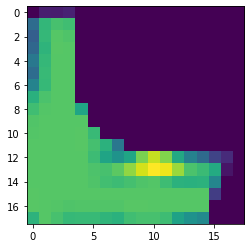

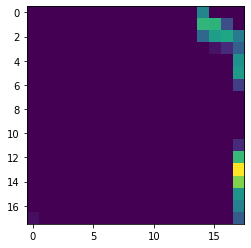

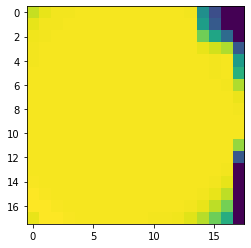

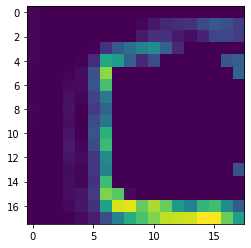

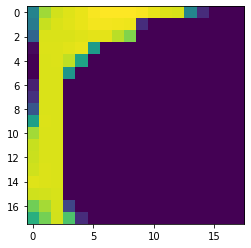

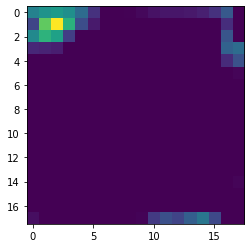

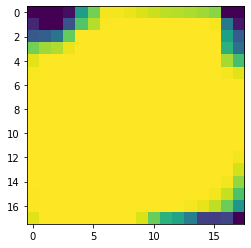

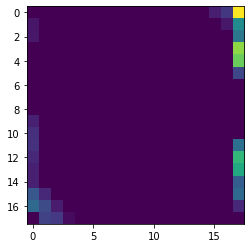

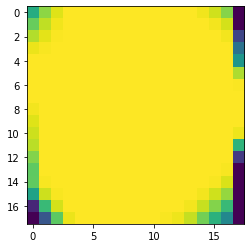

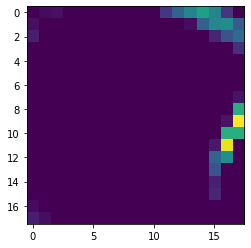

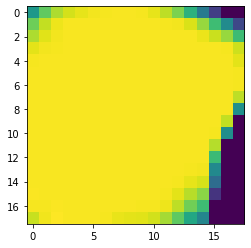

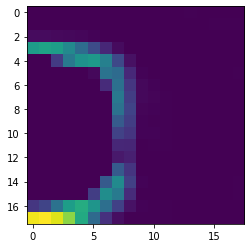

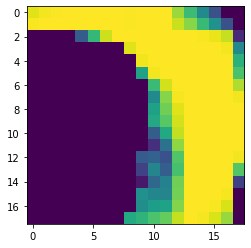

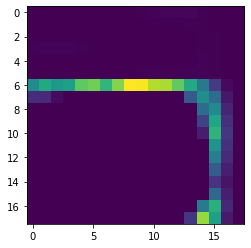

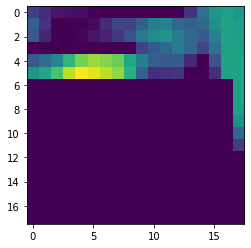

In [68]:
dataiter = iter(val_loader)
inputs, labels = dataiter.next()
images = inputs.numpy()
labels = labels.numpy()

outputs, features = net(inputs.to(device))
print(outputs.shape, features.shape)

for _, image in enumerate(features):
    image = image.cpu().detach().numpy()
    for i in range(len(image)):
        act = image[i]
        act = act.squeeze()
        plt.imshow(act)
        plt.show()

In [57]:
params = list(net.parameters())
# get weight only from the last layer(linear)
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
print(weight_softmax)

[[ 0.785763   -0.5270212 ]
 [-0.12534362  0.22414891]]


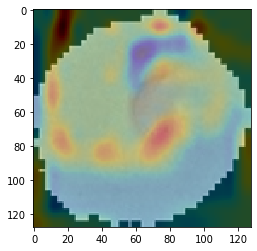

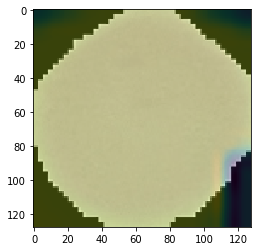

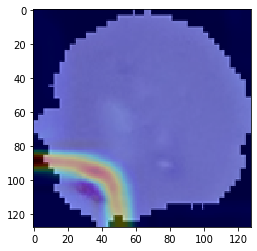

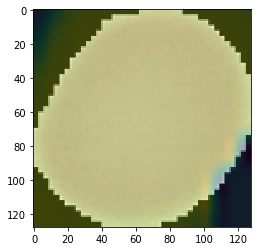

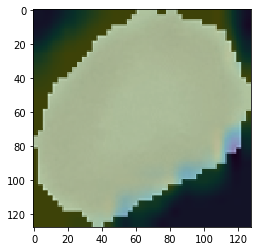

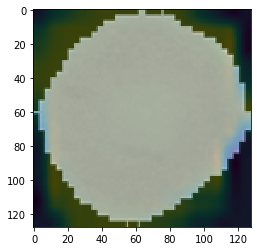

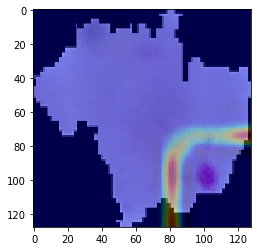

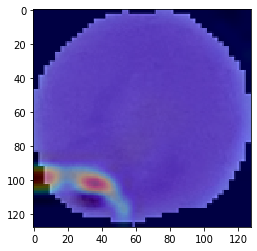

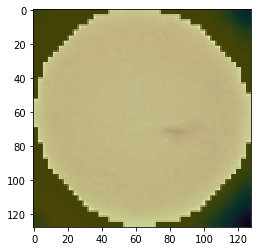

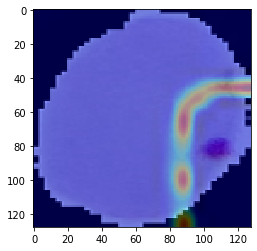

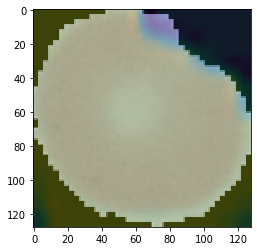

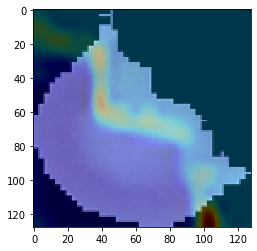

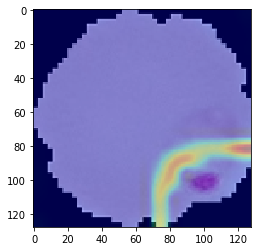

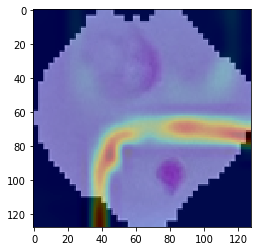

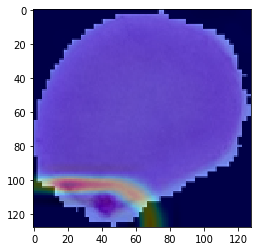

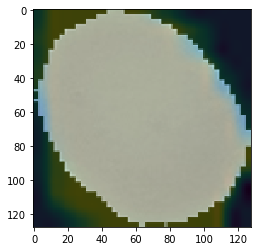

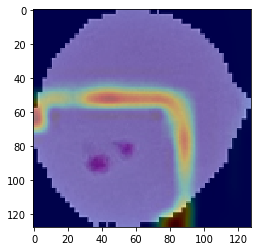

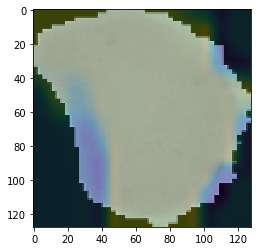

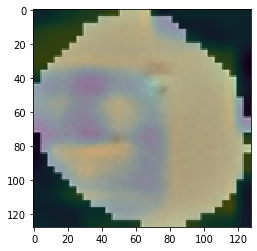

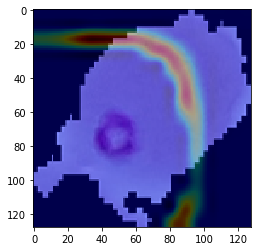

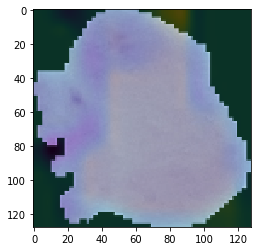

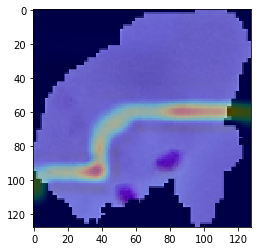

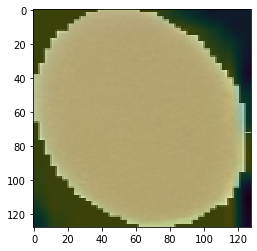

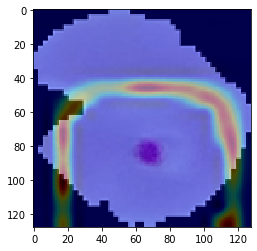

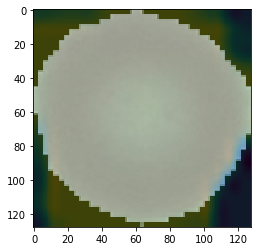

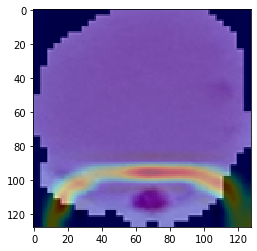

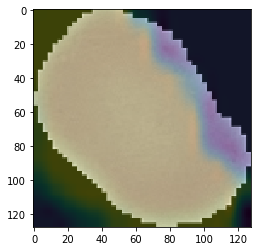

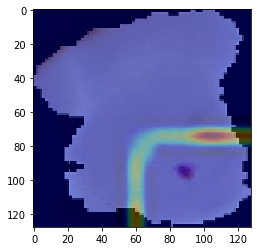

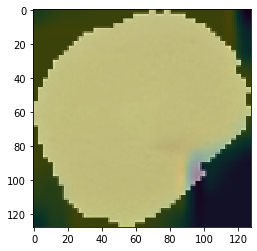

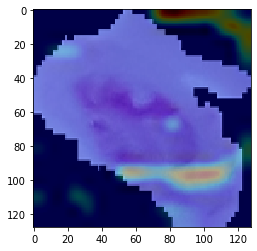

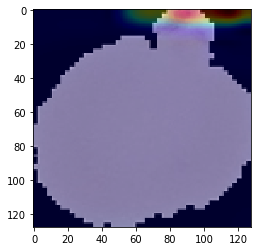

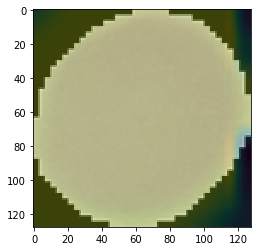

In [85]:
import cv2

dataiter = iter(val_loader)
inputs, labels = dataiter.next()
images = inputs.numpy()
labels = labels.numpy()

outputs, features = net(inputs.to(device))

for c, image in enumerate(features):

    true = images[c]
    label = labels[c]

    if label == 0:
        true = np.transpose(true, (1, 2, 0))

        image = image.cpu().detach().numpy()
        
        act1 = image[0] * (weight_softmax[0])[0]
        act2 = image[1] * (weight_softmax[0])[1]

        act = act1 + act2

        act = cv2.resize(act, (128, 128), interpolation=cv2.INTER_CUBIC)

        plt.imshow(true, interpolation='none')
        plt.imshow(act, 'jet', interpolation='none', alpha=0.3)
        plt.show()
    
    elif label == 1:
        true = np.transpose(true, (1, 2, 0))

        image = image.cpu().detach().numpy()
        
        act1 = image[0] * (weight_softmax[1])[0]
        act2 = image[1] * (weight_softmax[1])[1]

        act = act1 + act2

        act = cv2.resize(act, (128, 128), interpolation=cv2.INTER_CUBIC)

        plt.imshow(true, interpolation='none')
        plt.imshow(act, interpolation='none', alpha=0.3)
        plt.show()